# Dependencies loading

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.metrics import (accuracy_score, classification_report, confusion_matrix, 
                             roc_auc_score, roc_curve)
from sklearn.model_selection import RandomizedSearchCV

import warnings
warnings.filterwarnings('ignore')

# Data loading

In [5]:
base_url = "https://raw.githubusercontent.com/filipecorreia23/Bank-Term-Deposit-Prediction/main/output"

# importing datasets
X_train = pd.read_csv(f"{base_url}/X_train.csv")
X_test = pd.read_csv(f"{base_url}/X_test.csv")
y_train = pd.read_csv(f"{base_url}/y_train.csv")
y_test = pd.read_csv(f"{base_url}/y_test.csv")

print(X_train.shape, X_test.shape)
print(y_train.shape,y_test.shape)

(34554, 12) (8639, 12)
(34554, 1) (8639, 1)


# Model

## Encoding

As already explained, XGBoost cannot handle categorical data directly. Therefore, we converted all categorical variables into numeric format using label encoding. Each category was replaced with a unique numeric value, ensuring the data is compatible with XGBoost for effective processing.

In [9]:
# creating a dictionary to store LabelEncoder objects
label_encoders = {}

# lets slice the last 3 characters for 'contact_date'
X_train['contact_date'] = X_train['contact_date'].str[-3:]
X_test['contact_date'] = X_test['contact_date'].str[-3:]

# lets first create LabelEncoder for 'contact_date'
label_encoders['contact_date'] = LabelEncoder()

X_train['contact_date'] = label_encoders['contact_date'].fit_transform(X_train['contact_date'])
X_test['contact_date'] = label_encoders['contact_date'].transform(X_test['contact_date'])

# then, get all the categorical columns of object type
categorical_columns = X_train.select_dtypes(include=['object']).columns.difference(['contact_date'])

# encoding each categorical column
for column in categorical_columns:
    label_encoders[column] = LabelEncoder()
    
    # fit and transform for X_train
    X_train[column] = label_encoders[column].fit_transform(X_train[column])
    
    # transform X_test using the same encoder
    X_test[column] = label_encoders[column].transform(X_test[column])

# to print Encoding and Decoding
for column, encoder in label_encoders.items():
    print(f"\n{column} Encoding and Decoding:")
    
    encoded_values = range(len(encoder.classes_))
    decoded_values = encoder.classes_
    
    for enc, dec in zip(encoded_values, decoded_values):
        print(f"{enc} -> {dec}")


contact_date Encoding and Decoding:
0 -> apr
1 -> aug
2 -> dec
3 -> feb
4 -> jan
5 -> jul
6 -> jun
7 -> mar
8 -> may
9 -> nov
10 -> oct
11 -> sep

contact Encoding and Decoding:
0 -> cellular
1 -> telephone
2 -> unknown

education Encoding and Decoding:
0 -> primary
1 -> secondary
2 -> tertiary

job Encoding and Decoding:
0 -> admin.
1 -> blue-collar
2 -> entrepreneur
3 -> housemaid
4 -> management
5 -> retired
6 -> self-employed
7 -> services
8 -> student
9 -> technician
10 -> unemployed

marital Encoding and Decoding:
0 -> divorced
1 -> married
2 -> single

poutcome Encoding and Decoding:
0 -> failure
1 -> other
2 -> success


In [10]:
# initialize the model
xgb_model = XGBClassifier()

# fit the model
xgb_model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [11]:
# and make predictions
y_pred = xgb_model.predict(X_test)

## Model Evaluation

### Accuracy:

In [14]:
# lets start with accuracy
xgb_accuracy = accuracy_score(y_test, y_pred)
xgb_accuracy

0.9083227225373307

The model achieved 91% accuracy, showing good initial performance. Next, we should check other metrics like precision and recall to ensure it handles imbalances well.

### Classification Report:

In [19]:
# prediction probabilities
y_test_proba = xgb_model.predict_proba(X_test)[:, 1]

# classification report
report = classification_report(y_test, y_pred, target_names=["No", "Yes"])
print(report)

              precision    recall  f1-score   support

          No       0.93      0.96      0.95      7635
         Yes       0.64      0.48      0.55      1004

    accuracy                           0.91      8639
   macro avg       0.79      0.72      0.75      8639
weighted avg       0.90      0.91      0.90      8639



The model performs well for non-subscribers (class 0) with high precision and recall. However, it struggles to identify subscribers (class 1) with lower recall and f1-score. Overall accuracy is 91%, but improvements are needed for class 1 predictions.

### ROC AUC score:

In [25]:
auc_score = roc_auc_score(y_test, y_test_proba)
print(f"Test AUC: {auc_score:.4f}")

Test AUC: 0.9223


The Test AUC score of 0.9223 shows that the model performs very well in distinguishing between classes. A high AUC score reflects a strong ability to rank positive and negative instances correctly.

### Consusion Matrix:

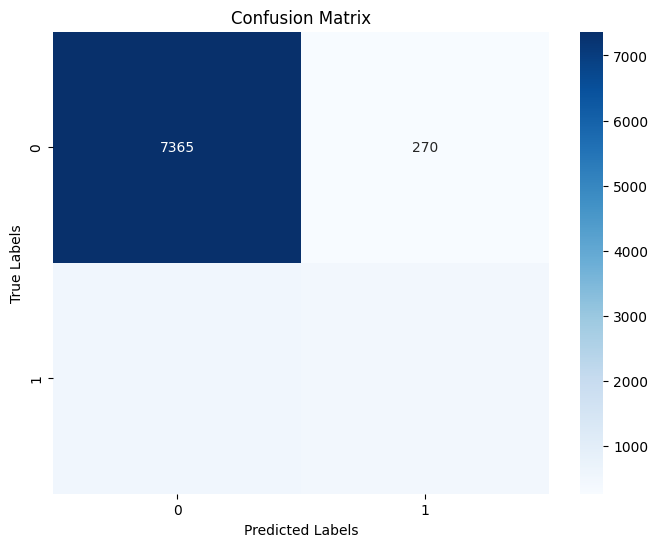

In [30]:
cm = confusion_matrix(y_test, y_pred)

# plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["0", "1"], yticklabels=["0", "1"])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

Again, the confusion matrix shows the model is great at predicting non-subscribers (class 0), but it struggles with subscribers (class 1).

### ROC curve:

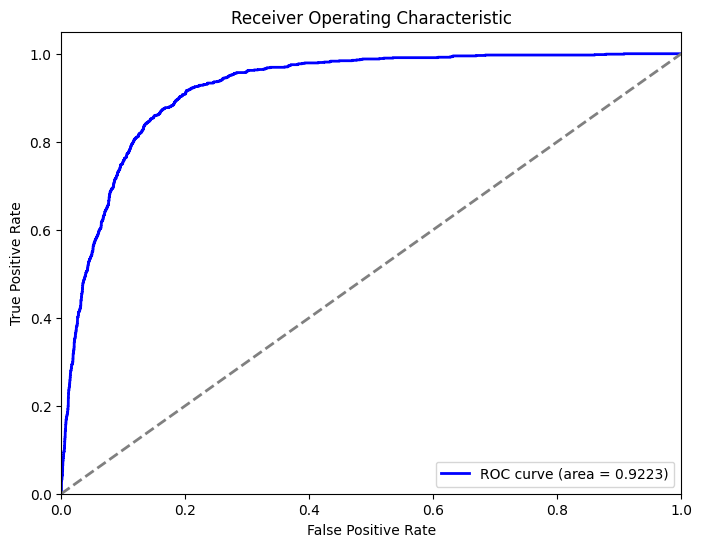

In [34]:
# prediction probabilities
y_test_proba = xgb_model.predict_proba(X_test)[:, 1]

fpr, tpr, _ = roc_curve(y_test, y_test_proba)

# plot ROC Curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {auc_score:.4f})')
plt.plot([0, 1], [0, 1], color='grey', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

Again, the ROC curve shows the model does a great job overall, with an AUC score of 0.9223. This means it’s good at telling the two classes apart. But, there’s a catch—it struggles with the smaller group (subscribers). Since most people in the dataset didn’t subscribe, the model gets really good at predicting them, but it misses more subscribers. To fix this, we might need to balance the data or tweak how the model learns.

## Hyperparameter tunning

Let's start by addressing the class imbalance in the dataset:

In [40]:
y_train_series = y_train.squeeze()

# number of positive and negative samples
num_negative = (y_train_series == 0).sum()
num_positive = (y_train_series == 1).sum()

# scale_pos_weight
scale_pos_weight = (num_negative / num_positive)

Here, we fine-tune the XGBoost model using RandomizedSearchCV to find the best settings and tackle class imbalance for better predictions:

In [43]:
# defining the parameter grid to search
param_dist = {
    'n_estimators': [50, 100, 200],  # number of trees
    'learning_rate': [0.01, 0.05, 0.1, 0.2],  # step size for updates
    'max_depth': [3, 5, 7, 10],  # maximum tree depth
    'min_child_weight': [1, 3, 5],  # minimum sum of weights of child nodes
    'subsample': [0.6, 0.8, 1.0],  # percentage of samples used per tree
    'colsample_bytree': [0.6, 0.8, 1.0],  # percentage of features used per tree
    'gamma': [0, 0.1, 0.2, 0.3],  # regularization parameter to avoid overfitting
    'scale_pos_weight': [scale_pos_weight]  # handle class imbalance
}

# initializing the XGBoost model
xgb_model = xgb.XGBClassifier()

# perform RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=xgb_model, 
    param_distributions=param_dist, 
    n_iter=20,       
    scoring='f1_micro',       
    cv=5,                     
    verbose=1,                
    random_state=42            
)

# fit the model
random_search.fit(X_train, y_train)

# best parameters found
print("Best Parameters: ", random_search.best_params_)

Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best Parameters:  {'subsample': 0.6, 'scale_pos_weight': 7.601941747572815, 'n_estimators': 200, 'min_child_weight': 3, 'max_depth': 10, 'learning_rate': 0.2, 'gamma': 0.3, 'colsample_bytree': 0.8}


In [44]:
# extract the best parameters from the random search
best_params = random_search.best_params_

# train the XGBoost model with the best parameters
bst = xgb.XGBClassifier(**best_params)

# fit the model
bst.fit(X_train, y_train)

# make predictions
bst_preds = bst.predict(X_test)

## Model Evaluation

### Classification report:

In [47]:
report = classification_report(y_test, bst_preds, target_names=["No", "Yes"])
print(report)

              precision    recall  f1-score   support

          No       0.95      0.91      0.93      7635
         Yes       0.49      0.64      0.56      1004

    accuracy                           0.88      8639
   macro avg       0.72      0.78      0.74      8639
weighted avg       0.90      0.88      0.89      8639



The improvements in f1-score were modest, even after experimenting with various scale adjustments, and came at the expense of overall accuracy. However, the recall for true positives—our primary objective—improved significantly, showing better identification of potential subscribers.

### ROC curve:

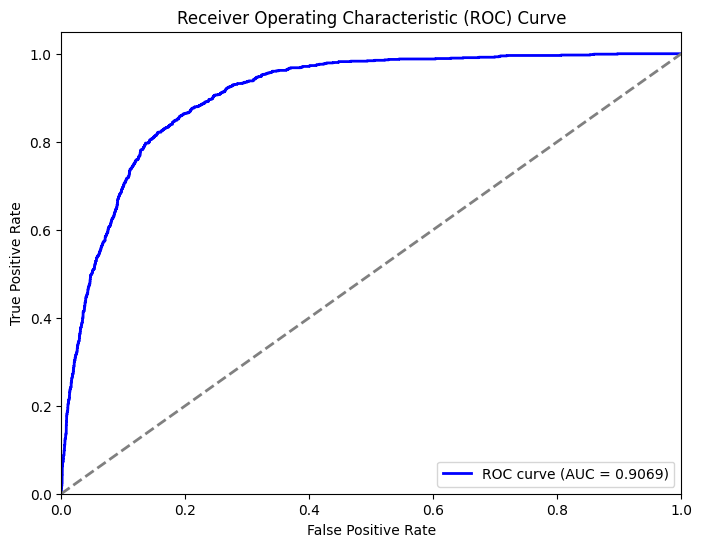

In [51]:
# prediction probabilities
y_test_proba = random_search.best_estimator_.predict_proba(X_test)[:, 1]

# ROC AUC score
auc_score = roc_auc_score(y_test, y_test_proba)

# ROC curve
fpr, tpr, _ = roc_curve(y_test, y_test_proba)

# plot
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {auc_score:.4f})')
plt.plot([0, 1], [0, 1], color='grey', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

The AUC score slightly decreased, but it’s nothing to be concerned about. The trade-off is worth it as the recall for true positives—our primary objective—improved significantly.

### Confusion Matrix

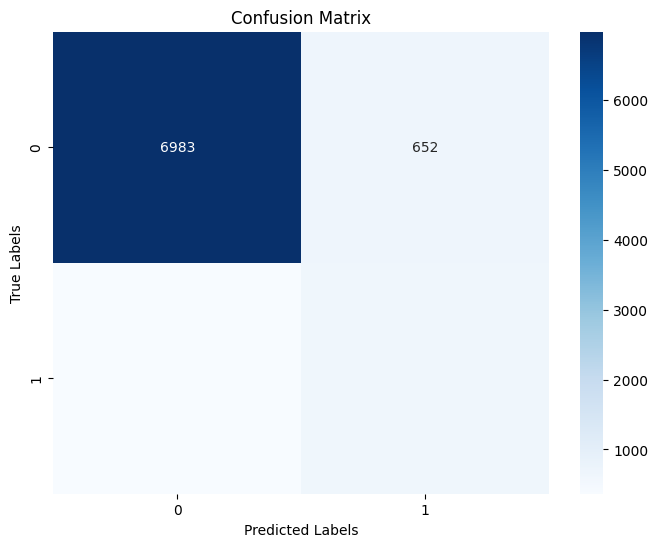

In [57]:
# make predictions
y_pred = random_search.best_estimator_.predict(X_test)

cm = confusion_matrix(y_test, y_pred)

# plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["0", "1"], yticklabels=["0", "1"])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

After hyperparameter tuning, the matrix shows an increase in correctly identified subscribers, though some misclassifications remain.

## Feature selection:

Feature selection is all about finding the most important pieces of data to focus on. It helps simplify the model, makes it run faster, and improves it by cutting out the noise. It’s like keeping only what truly matters!

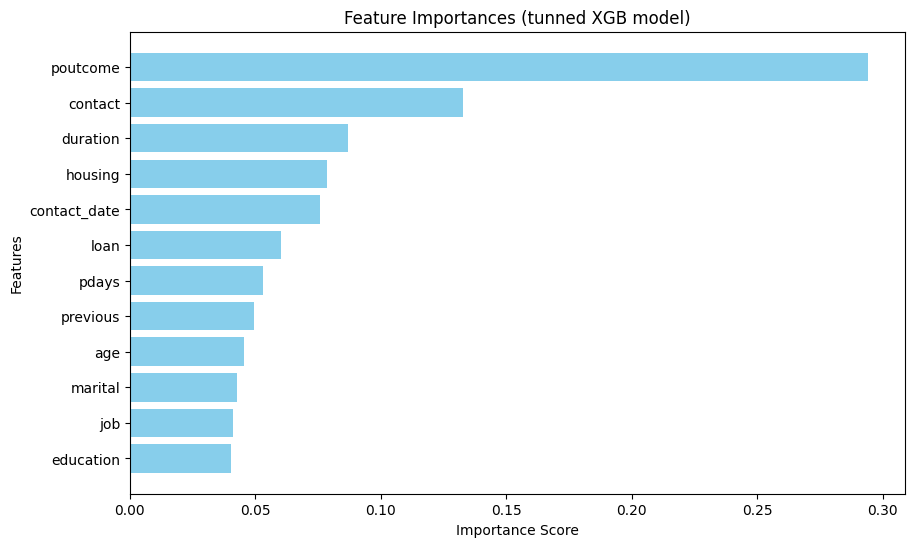

In [61]:
# get feature importances from the hp tunned model
headers = ["name", "score"]
values = sorted(zip(X_train.columns, bst.feature_importances_), key=lambda x: x[1] * -1)
feature_importances = pd.DataFrame(values, columns=headers)

features = feature_importances.head(12)

# plot
plt.figure(figsize=(10, 6))
plt.barh(features['name'], features['score'], color='skyblue')
plt.xlabel('Importance Score')
plt.ylabel('Features')
plt.title('Feature Importances (tunned XGB model)')

plt.gca().invert_yaxis()
plt.show()

Let's filter using a 5% threshold:

In [63]:
important_features = feature_importances[feature_importances['score'] > 0.05]['name'].tolist()
important_features

['poutcome', 'contact', 'duration', 'housing', 'contact_date', 'loan', 'pdays']

In [64]:
# let's filter on important features
X_train_filtered = X_train[important_features]
X_test_filtered = X_test[important_features]

# initialize the tunned model
xgb_model_filtered = xgb.XGBClassifier(**random_search.best_params_)

# and retrain the model on the filtered dataset
xgb_model_filtered.fit(X_train_filtered, y_train)

# lets make predictions
y_pred_filtered = xgb_model_filtered.predict(X_test_filtered)

## Model Evaluation

### Classification report:

In [67]:
filtered_report = classification_report(y_test, y_pred_filtered, target_names=["No", "Yes"])
print(filtered_report)

              precision    recall  f1-score   support

          No       0.96      0.86      0.91      7635
         Yes       0.42      0.76      0.54      1004

    accuracy                           0.85      8639
   macro avg       0.69      0.81      0.73      8639
weighted avg       0.90      0.85      0.87      8639



Significant improvement in Recall, meaning we’re catching more of the true positives!

### ROC curve:

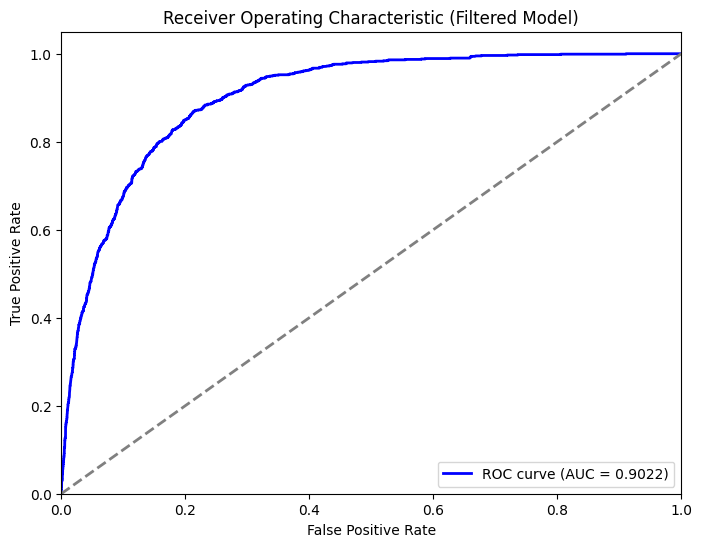

In [70]:
# get predicted probabilities for the filtered model
y_test_proba_filtered = xgb_model_filtered.predict_proba(X_test_filtered)[:, 1]

# ROC AUC score
auc_score_filtered = roc_auc_score(y_test, y_test_proba_filtered)

# ROC curve
fpr_filtered, tpr_filtered, _ = roc_curve(y_test, y_test_proba_filtered)

# plot
plt.figure(figsize=(8, 6))
plt.plot(fpr_filtered, tpr_filtered, color='blue', lw=2, label=f'ROC curve (AUC = {auc_score_filtered:.4f})')
plt.plot([0, 1], [0, 1], color='grey', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (Filtered Model)')
plt.legend(loc="lower right")
plt.show()

Basically the same!

### Confusion matrix:

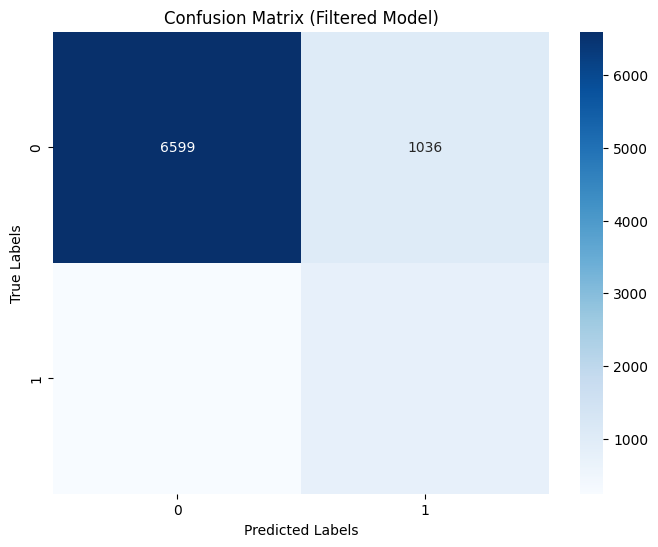

In [73]:
# make predictions
y_pred_filtered = xgb_model_filtered.predict(X_test_filtered)

# confusion matrix (filtered)
cm_filtered = confusion_matrix(y_test, y_pred_filtered)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm_filtered, annot=True, fmt='d', cmap='Blues', xticklabels=["0", "1"], yticklabels=["0", "1"])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix (Filtered Model)')
plt.show()

The filtered model shows a clear improvement in identifying the "Yes" class, with more true positives successfully captured. However, there is a trade-off, as some true negatives are now misclassified.

# Summary

After filtering and parameter tuning, our model shows a balance between precision and recall, especially for subscribers ("Yes"). The **accuracy decreased to 85%**, reflecting the trade-off for better handling of imbalanced classes. Precision for "Yes" is **42%**, meaning the model's predictions for subscribers often include false positives. However, the recall improved significantly to **76%**, showing that the model captures more true subscribers, which is crucial for identifying valuable leads. For non-subscribers ("No"), the model maintains high precision (**96%**) and a decent recall (**86%**). The AUC score of **0.9022** confirms the model's overall ability to separate the classes effectively. While true negatives dominate, reducing false negatives remains a priority to increase campaign efficiency and maximize potential conversions.